In [1]:
# Load code and required packages
using Plots
using Distributions
using CSV, DataFrames
using Statistics
import Random

Random.seed!(1)

include("GP.jl");

There are only two small tasks for you at the bottom of the notebook.

# Testing the GP implementation on some toy data

After implementing the missing functions in GP.jl and passing the test you can use this section the as an additional verification of your implementiation. When running the notebook the plots should look roughly the same as before.

## Plotting samples from prior with rbf kernel 

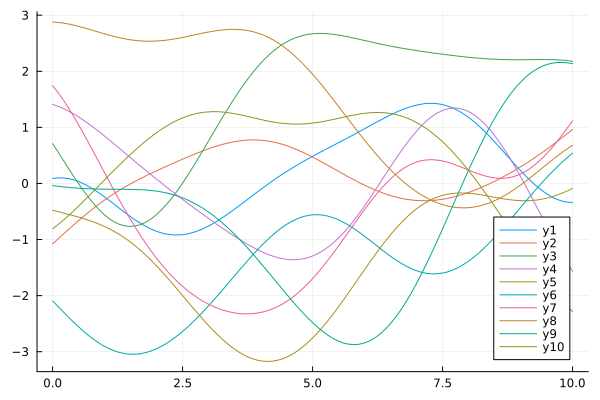

In [2]:
# plot samples from prior with rbf kernel
x = 0:0.01:10 |> collect
theta = (2, 0.000001, [2])
C = kernelmat(x, x, rbf_kernel, theta)
distribution = MvNormal(zeros(length(x)), C)

# generate some samples of the prior:
sample_count = 10
# each x will get a y sampled from the multivariate distribution (per sample function)
ys = rand(distribution, sample_count)

p = plot()
for i in 1:sample_count
    plot!(x, ys[:,i])
end

display(p)

## Generate toy data

We generate data for g(x) with some noise. The noise has a standard deviation of σ_n=0.1.

In [3]:
# Generate Data
function g(x)
    return sin.(x) .+ x
end

d = Uniform(0, 10)
x = rand(d, 20)
σ_n = 0.1
noise = σ_n*randn(length(x))
y = g(x) + noise;

## GP without optimized hyperparameters

You will see that the learned function does not fit the data very well.

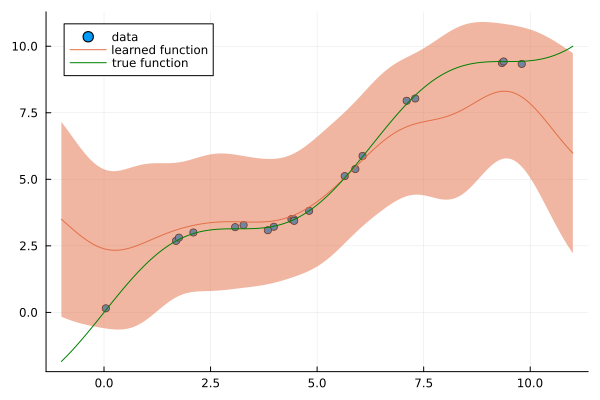

In [4]:
# Train GP with arbitrary theta and plot solution
# mind that we have to center our data to have a zero mean
# and take this transformation into account when predicting as well
theta = (1, 1, [1])
# we need to subtract the mean from y so that the data is centered around 0
gp = train_gp(x, y .- mean(y), rbf_kernel, theta)

x_pred = -1:0.01:11 |> collect
y_pred = predict_gp(gp, x_pred)

# after we are done with the gp we need to add the mean back to the prediction
μ_pred = y_pred[1] .+ mean(y)
σ2_pred = 2*y_pred[2] # sigma^2 in both directions

scatter(x, y, label = "data")
plot!(x_pred, μ_pred, ribbon = σ2_pred, label = "learned function")
plot!(x_pred, g(x_pred), color = :green, label = "true function")

## Finding better hyperparameters

We want to find kernel parameters that maximize the probability of seeing the training data (the marginal likelihood). So called Gaussian process evidence maximization.
There are three hyperparameters we have to tune: `σ2_f`, `σ2_n` and `λ` for an RBF kernel that we are applying throughout this notebook.

From the data generation process we know that the data noise standard deviation `σ_n` is 0.1 so the variance `σ2_n` is 0.01. We will fix this parameter since we don't want to optimize it. Mind that the gradient for the parameter `σ2_n` is set to 0 in grad_rbf(), this way `σ2_n` will not be updated during optimization.

To optimize the other two parameters `σ2_f` and `λ` we will search over a grid of the two parameters. So we will compute the marginal likelihood over the training data by training a GP with those hyperparameters.

Using a countour plot, we can [visually examine](https://en.wiktionary.org/wiki/graduate_student_descent) which combinations of parameters maximize the marginal likelihood.

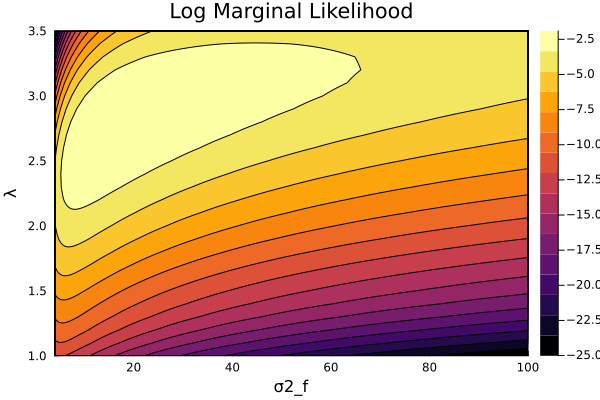

In [5]:
σ2_n = 0.01 # fixed noise variance

function get_lml(σ2_f, λ)
    gp = train_gp(x, y .- mean(y), rbf_kernel, (σ2_f, σ2_n, [λ]))
    return log_m_likelihood(gp)
end

# defining the grid
σ2_f_values = 4.0:0.1:100.0
λ_values = 1.0:0.1:3.5

lml = get_lml.(σ2_f_values', λ_values)

contourf(σ2_f_values, λ_values, lml, title="Log Marginal Likelihood")
xlabel!("σ2_f")
ylabel!("λ")

We now use the Gradient Descent (actually gradient ascent here) algorithm to find the maximum of the marginal likelihood function. The `σ2_f` and `λ` at that point are the optimal hyperparameters. The functions implementing the gradient descent algorithm as are already implemented for you.

In gradient descent we start at a random `σ2_f` and `λ` and work ourselves in small steps upwards the function. In each step we go in the direction of the gradient of the function with regard to the parameters to find the highest point of the function.

In [6]:
theta_start = (40.0, σ2_n, [2.0])
theta_optimized, not_optimal_thetas = optimize_theta(x, y .- mean(y), theta_start;
    stepsize=[1e0, 0.0, 1e-3],
    eps=1e-5,
    max_iter=1000);

Status: -1


In [7]:
σ2_fs = [t[1] for t in not_optimal_thetas]
λs = [t[3] for t in not_optimal_thetas];

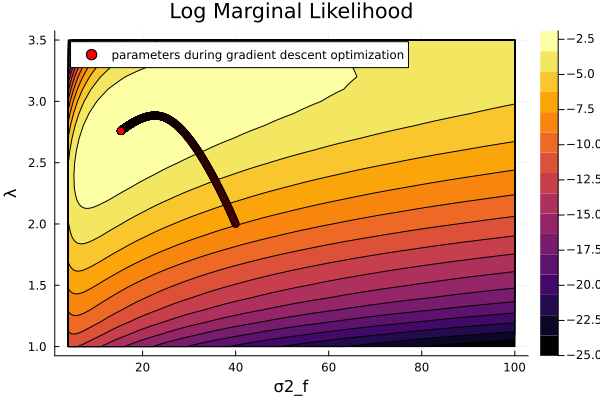

In [8]:
contourf(σ2_f_values, λ_values, lml, title="Log Marginal Likelihood")
scatter!(σ2_fs, λs, color = :red, label = "parameters during gradient descent optimization")
xlabel!("σ2_f")
ylabel!("λ")

Now we use these optimized hyperparameters to train the GP one more time.

That function looks alot better! The function does fit the points and there is uncertainty at the areas where no points have been observed.

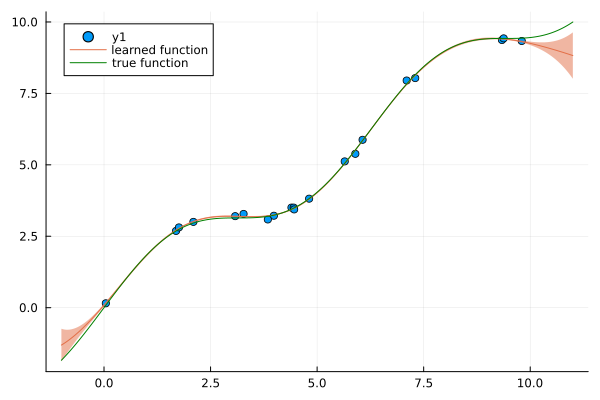

In [9]:
# Retrain GP with best theta and plot solution
gp = train_gp(x, y .- mean(y), rbf_kernel, theta_optimized)

x_pred = -1:0.01:11 |> collect
pred = predict_gp(gp, x_pred)
μ_pred = pred[1] .+ mean(y)
σ2_pred = 2*pred[2]
scatter(x, y)
plot!(x_pred, μ_pred, ribbon = σ2_pred, label = "learned function")
plot!(x_pred, g.(x_pred), color = :green, label = "true function")

# Real world dataset to find kernel parameters yourself

In this example we use a Gaussian Process to predict the accumulated sun hours over a year in Germany. You have collected data from several weather stations in Germany. A weather station measures the sun hours at that position over the year, its position is stated by latitude, longitude values.

In [10]:
#Load Sunshine Data
SunshineData = CSV.read("data/SunshineData.csv", DataFrame)

DataGermany = SunshineData[SunshineData.Country .== "Germany",:]
#filter out Neumayer (Antarctica)
mask = DataGermany[:,:StationName] .!= "Neumayer"
DataGermany = DataGermany[mask,:]

X = Array(DataGermany[:,[:Latitude, :Longitude]])
# get sun hours for each month
y = Array(DataGermany[:,2:13])
# accumulate sun hours over the yea
y = vec(sum(y, dims = 2))
# var(y)

187-element Vector{Float64}:
 1682.8000000000002
 1713.9999999999995
 1549.8000000000002
 1485.6000000000001
 1598.2
 1545.4
 1626.5
 1740.7
 1805.1000000000001
 1715.1
    ⋮
 1690.9000000000003
 1755.1000000000001
 1755.1000000000001
 1596.3
 1846.3999999999996
 1820.4
 1668.3999999999999
 1675.8000000000002
 1726.0

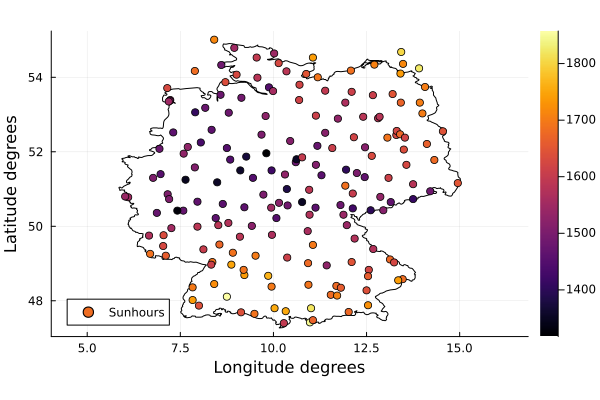

In [11]:
border = CSV.read("data/GermanBorder.csv", DataFrame)
plot(border[:,1], border[:,2], color="black", aspect_ratio = :equal, label = false)
scatter!(X[:,2], X[:,1], zcolor = y, label = "Sunhours")
xlabel!("Longitude degrees")
ylabel!("Latitude degrees")

The first step is again to find good hyperparameters.
This time we will not use Gradient Descent for this purpose. Instead we only look at the marginal likelihood plot and choose the hyperparameters that maximize the marginal likelihood.

Mind that we now have two length scale values λ one for latitude and one for longitude. To simplify the task we let them be the same.

Now, as we have done in the toy dataset, we will have to fix one of the parameters so we can visualize the marginal likelihood in 2D. For example you can fix σ2_f (by taking a look at how much sun hours across Germany vary) as done in the code below. Feel free to fix any of three parameters, not necessarily σ2_f. It makes sense to fix the parameter we can make the best initial guess about. The goal of this task is to identify an area in the contour plot (combination of parameters) in which the marginal likelihood does not change anymore so we can assume that picking any of these combinations is a good enough choice.

The kernel parameters that we find should seem logical using your domain knowledge of sun hours.

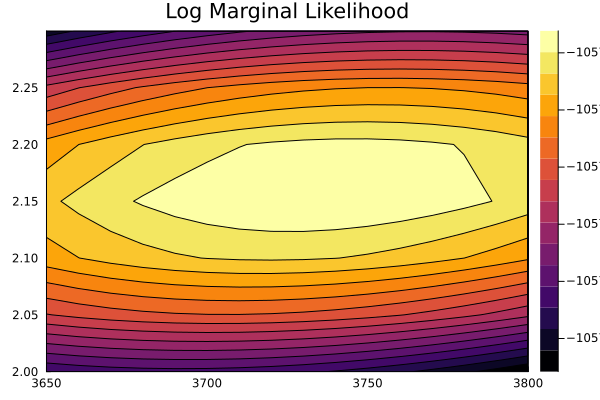

In [12]:
σ2_f = 12000

function get_lml(σ2_n, λ)
    gp = train_gp(X, y .- mean(y), rbf_kernel, (σ2_f, σ2_n, [λ, λ]))
    return log_m_likelihood(gp)
end

# defining the grid
σ2_n_values = 3650:10:3800
λ_values = 2.0:0.05:2.3

lml = get_lml.(σ2_n_values', λ_values)

contourf(σ2_n_values, λ_values, lml, title="Log Marginal Likelihood")

## Plot the sunhour map with your choice of parameters

By picking reasonable parameter values for "theta" from your plot above the sunhour map below should look somewhat like the one that is given.

In [13]:
theta = (12000, 3700.0, [2.0, 2.0])

(12000, 3700.0, [2.0, 2.0])

In [14]:
# Create X_pred
lat_max, long_max = maximum(X, dims = 1) .+ 0.25
lat_min, long_min = minimum(X, dims = 1) .- 0.25
lat = lat_min:0.1:lat_max
long =  long_min:0.1:long_max
X_pred = Iterators.product(lat, long) |> collect
X_pred = [first.([X_pred...]) last.([X_pred...])];

# Get predictions
gp_sun = train_gp(X, vec(y).-mean(y), rbf_kernel, theta)
sun_pred = predict_gp(gp_sun, X_pred);

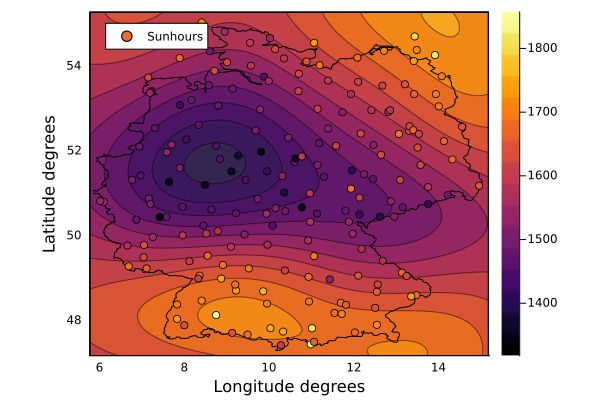

In [15]:
z_matrix = reshape(sun_pred[1], length(lat), length(long))

contourf(long, lat, z_matrix .+ mean(y), alpha = 0.5, ylim = (lat_min, lat_max), xlim = (long_min, long_max), clims=(minimum(y), maximum(y)))
plot!(border[:,1], border[:,2], color="black", aspect_ratio = :equal, label = false)
scatter!(X[:,2], X[:,1], zcolor = y, label = "Sunhours")
xlabel!("Longitude degrees")
ylabel!("Latitude degrees")